# Setting up the Google Colab
The easiest way to run this is through Google Colab. However, to get it the colab to access the data we will need to give access to the data. The easiest way to is to download the GitHub page and upload it to Google Drive. If you keep the same name as the repo (ICAMPAM-participant), you should be able to just run it. Otherwise, change the 'folder_name' variable.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
folder_name = 'ICAMPAM-participant'
folder_path = f'/content/drive/MyDrive/{folder_name}/DATA'

# Importing the necessary libraries
We will start with a few basic things that we have already written for you. We have imported a few libraries, but if you feel like another library is more fitting,
or you are more familiar with another library, feel free to use that one instead.

If you are using your own python install, make sure scipy's version is not older than 1.12. We are using a scipy function (cumulative simpson) for the integration of the accelerations, and this was introduced since v.1.12. If the scipy version is older, uncomment the last line and rerun this block.

In [19]:
from scipy import io
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Defining load .mat files function:
print(f'Scipy version =  {scipy.__version__}') # Make sure version > 1.12 for cumulative simpson integral
#!pip install --upgrade scipy

Scipy version =  1.13.1


# Loading in the data
As the data from the sensors was retrieved and saved through matlab, the files are of .mat extension. The io library has a function for reading these files, but it doesn't load the data in a nice and ready-to-use format. For that, we will need to select the right sensors (sensor_names) and name of the original matlab variable (key). As we don't consider loading in data part of the workshop, we have written this for you. If you do have questions about this part, feel free to ask.

In [20]:
def load_data(file_path, sensor_names, key):
    data = io.loadmat(file_path, squeeze_me = True)
    sensor_data = {}
    for sensor_name in sensor_names:
        try:
            sensor_data[sensor_name] = data[key][sensor_name]
        except ValueError:
            raise ValueError(f"Error: Unknown sensor. Check if '{sensor_name}' is spelled correctly or exist")
        except KeyError:
            raise KeyError(f"Error: Unknown key. Check if '{key}' is spelled correctly or exist")
    return sensor_data

# Define the sensor names
sensor_names = ['hand_IMU','lowerarm_IMU', 'upperarm_IMU', 'shoulder_IMU', 'sternum_IMU']

# Load each .m file
Trials_left_acc = load_data('DATA/trials_ACCbf_Left_p10.mat', sensor_names, 'trials_ACCbf_Left')
Trials_right_acc = load_data('DATA/trials_ACCbf_Right_p10.mat', sensor_names, 'trials_ACCbf_Right')
Trials_R_Left_bf2seg= load_data ('DATA/Trials_R_Left_bf2seg_p10.mat', sensor_names, 'trials_R_Left_bf2seg')
Trials_R_Right_bf2seg= load_data ('DATA/Trials_R_Right_bf2seg_p10.mat', sensor_names, 'trials_R_Right_bf2seg')
Trial_L_raw_acc = load_data('DATA/Trials_Left_acc_p10.mat', sensor_names, 'trials_acc')
Trial_R_raw_acc = load_data('DATA/Trials_Right_acc_p10.mat', sensor_names, 'trials_acc')


# Intuition on accelerations
Before we get into the analysis, let's briefly make sure everything is alright. We are doing a reach and return movement. Logically, in the direction of the reach movement (x-axis) we should expect a:
1. Brief acceleration period to move our arm towards the object
2. Deacceleration once we near the object. Slowing ourselves down to not overshoot the target
3. Negative acceleration to move back towards the starting point.
4. An acceleration to slow down the backwards motion and return to rest.

If we have selected our trial correctly, this is what we expect to see. For now, we will only check the hand IMU, as the end effector gives the most intuitive results. Let's make some plots to confirm this!

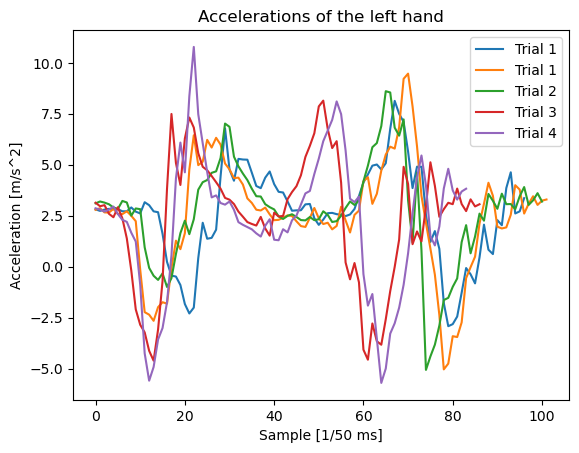

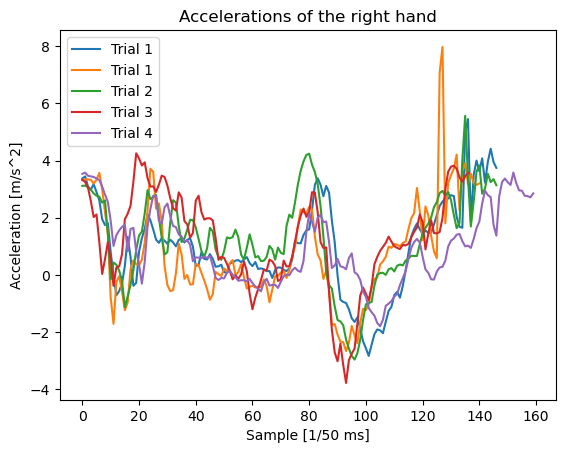

In [21]:
raw_acc_left_hand = Trial_L_raw_acc["hand_IMU"].tolist()
for i, accelerations in enumerate(raw_acc_left_hand):
    plt.plot(accelerations[:,0])
plt.title("Accelerations of the left hand")
plt.legend(["Trial 1" ,"Trial 1", "Trial 2", "Trial 3", "Trial 4", "Trial 5"])
plt.ylabel("Acceleration [m/s^2]")
plt.xlabel("Sample [1/50 ms]")
plt.show()

raw_acc_right_hand = Trial_R_raw_acc["hand_IMU"].tolist()
for i, accelerations in enumerate(raw_acc_right_hand):
    plt.plot(accelerations[:,0])
plt.title("Accelerations of the right hand")
plt.legend(["Trial 1" ,"Trial 1", "Trial 2", "Trial 3", "Trial 4", "Trial 5"])
plt.ylabel("Acceleration [m/s^2]")
plt.xlabel("Sample [1/50 ms]")
plt.show()

# Correcting the offset
We can already see that the reaching movement on the right side is less well-defined than on the left side. Looking at this, it may be unsurprising for some of us to learn that the right side also happens to be the impaired arm. Let us keep that in mind for the next exercises and see if we can quantify that somehow. Although we have the general shape we excepted, we can see that the axes are mirrored: when we excepted a positive peak, we have a negative and vice-versa. This won't matter too much, except that our directions are reversed. Positive is backwards, negative is forwards.

Let's make some observations that might give us some intuition about the quality features first.
1. It appears that to capture the entire movement, we need more samples for the right arm than for the left arm (mind the x-axis). This means that the movements, probably, take longer to complete.
2. The accelerations appear larger on the left arm. This could translate to the unimpaired arm having higher peak velocities.
3. The accelerations on the left side appear to have less fluctuations, less noisy. Maybe the movement is also considered smoother.

Before we start, as the trial starts and ends with zero velocity, the mean accelerations should be zero. This is not the case right now, and we should fix that.



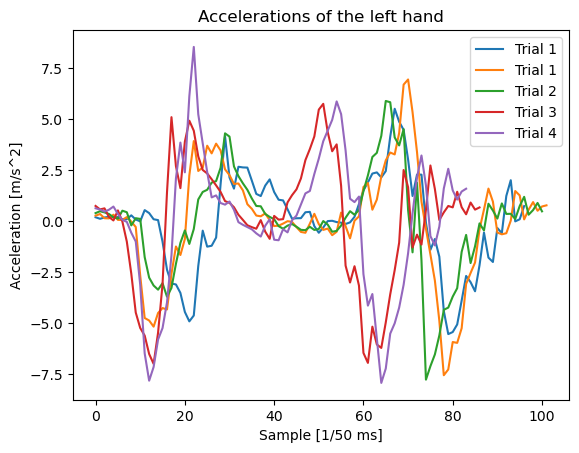

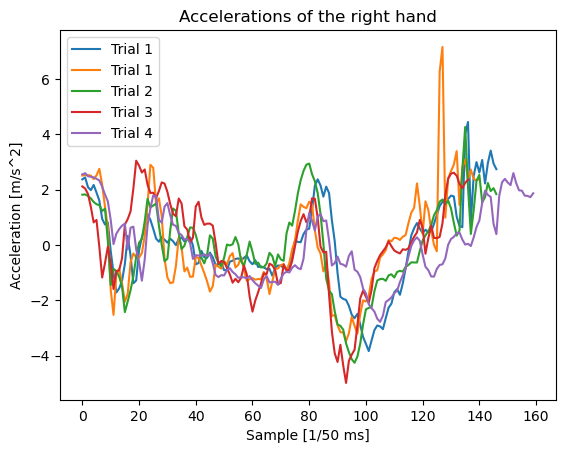

In [22]:
def zero_mean(vector):
    #This function takes a vector and adjusts the mean to zero
    correction = np.mean(vector)
    vector = vector - correction
    return vector
zero_mean_left_acc_hand = []
for trial_num, trial_acc in enumerate(raw_acc_left_hand):
    df_acc = pd.DataFrame(trial_acc, columns= ["x", "y", "z"])
    df_acc["x"] = zero_mean(df_acc["x"])
    df_acc["y"] = zero_mean(df_acc["y"])
    df_acc["z"] = zero_mean(df_acc["z"])
    zero_mean_left_acc_hand.append(df_acc)

zero_mean_right_acc_hand = []
for trial_num, trial_acc in enumerate(raw_acc_right_hand):
    df_acc = pd.DataFrame(trial_acc, columns= ["x", "y", "z"])
    df_acc["x"] = zero_mean(df_acc["x"])
    df_acc["y"] = zero_mean(df_acc["y"])
    df_acc["z"] = zero_mean(df_acc["z"])
    zero_mean_right_acc_hand.append(df_acc)

for i, accelerations in enumerate(zero_mean_left_acc_hand):
    plt.plot(accelerations["x"])
plt.title("Accelerations of the left hand")
plt.legend(["Trial 1" ,"Trial 1", "Trial 2", "Trial 3", "Trial 4", "Trial 5"])
plt.ylabel("Acceleration [m/s^2]")
plt.xlabel("Sample [1/50 ms]")
plt.show()

for i, accelerations in enumerate(zero_mean_right_acc_hand):
    plt.plot(accelerations["x"])
plt.title("Accelerations of the right hand")
plt.legend(["Trial 1" ,"Trial 1", "Trial 2", "Trial 3", "Trial 4", "Trial 5"])
plt.ylabel("Acceleration [m/s^2]")
plt.xlabel("Sample [1/50 ms]")
plt.show()


# Movement time
Let us start with the first observation: The movement times. If know the length of the trial data, we know how many samples it took to complete the movement. Then, if we also know the sample rate, we can tell how long the movement took by dividing the trial length by the sample frequency. Let's get started with the first coding exercise. We will have to write a simple function to calculate the movement time based on:
1. The length of the trial, and
2. The sample frequency

We have added some fluff around so that you only need to fill in the actual function below in "calc_movement_time".


In [23]:
def calc_movement_time(acceleration, fs):
    '''
    Input: Acceleration of a single trial and sample frequency (fs)
    Calculates the trial duration based on the length of trial and sample frequency
    '''
    #calculate the total time of the trial.

    return total_time

sensor = "hand_IMU"
fs = 50
movement_times = []
list_acc_data = [zero_mean_left_acc_hand, zero_mean_right_acc_hand]
for acc_side in list_acc_data:
    for trial_acc in acc_side:
        #Calculate features
        movement_time = calc_movement_time(trial_acc, fs)
        #Append Features to list
        movement_times.append(movement_time)

trials = [1, 2, 3, 4, 5]
plt.plot(trials, movement_times[0:5])
plt.plot(trials, movement_times[5:])
plt.title("Movement time of left and right arm")
plt.legend(["Left", "Right"])
plt.xlabel("Trial")
plt.xticks(trials)
plt.ylabel("Movement time [s]")
plt.show()

NameError: name 'total_time' is not defined

Based on this figure - and steering far, far away from statistics - it would appear that the movement times of left and right are indeed different. Feel free to create some other plots to observe the differences in movement time.

# Velocity

Now let us dive into the velocities. First and foremost, a disclaimer. Since we are using accelerations and integrating these to obtain velocities, there are some errors that occur and propagate. One source of these errors is that the accelerations is not a continuous function, but a discrete measurement, meaning we have a finite number of samples. In between these measurements we are missing information, and we need to make some assumptions to deal with this.

Another source of errors is from the sensors itself. Since we have a relatively short measurement time, at least mathematically speaking, we cannot expect that this measurement noise is zero mean, even though the underlying process might be. As such, velocities measured from IMUs are not as accurate as velocities measured from a motion tracking based set-up and can bias the velocities that we have.

As not every participant has a background with numerical mathematics, we will supply the function to integrate accelerations to velocities. We are particularly interested in the first part of the movement, where the subject reaches towards the target. As such, we will also select only a part of the velocity. This has been done fairly crudely (Using the first zero crossing of the x-axis after a certain index), we are still researching better ways to automatically identify the end of a goal-directed movement. Furthermore, we have made all x-movements positive towards the target.


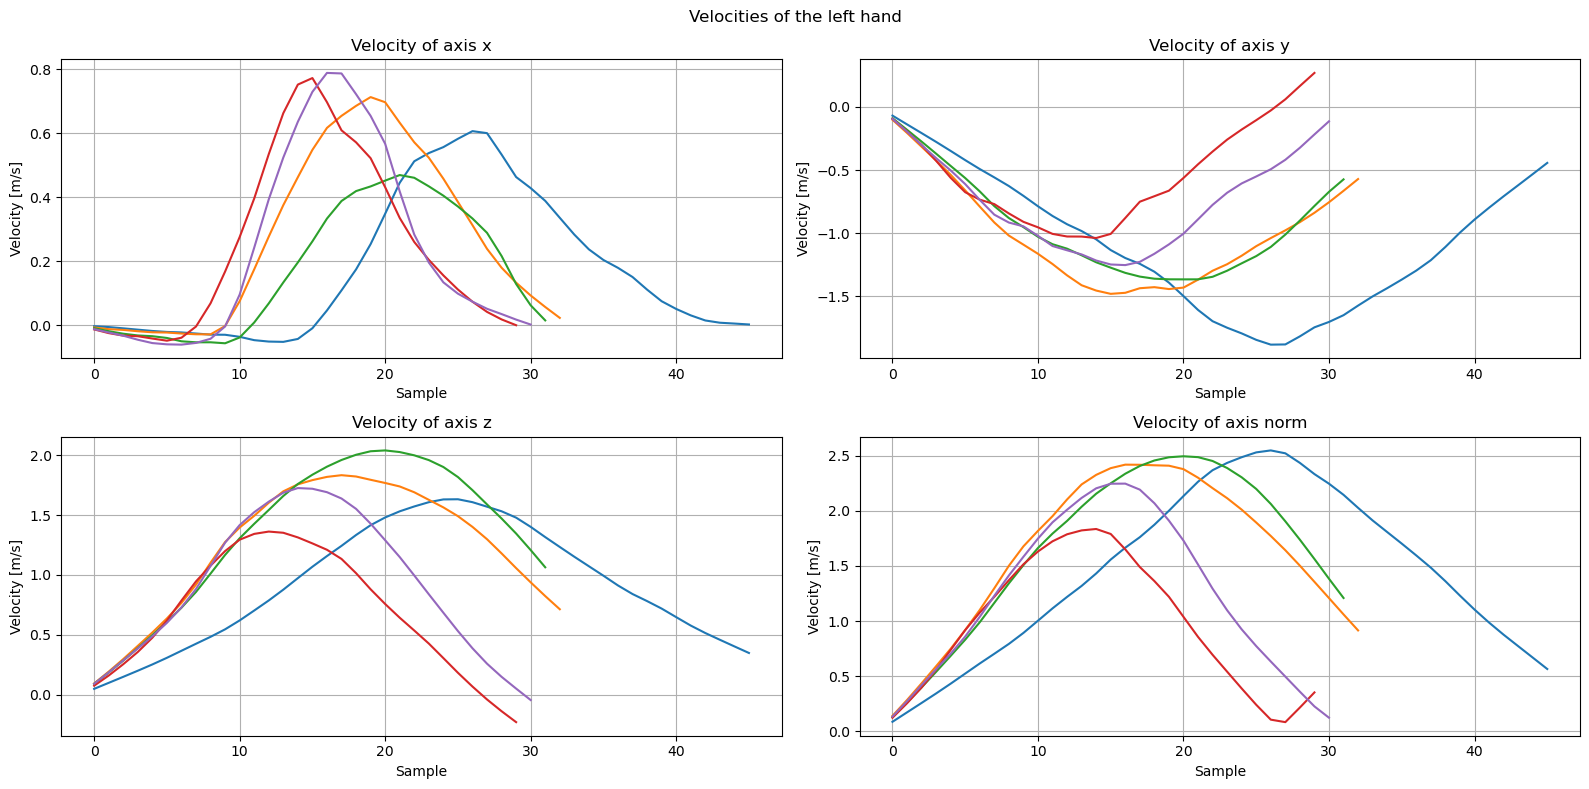

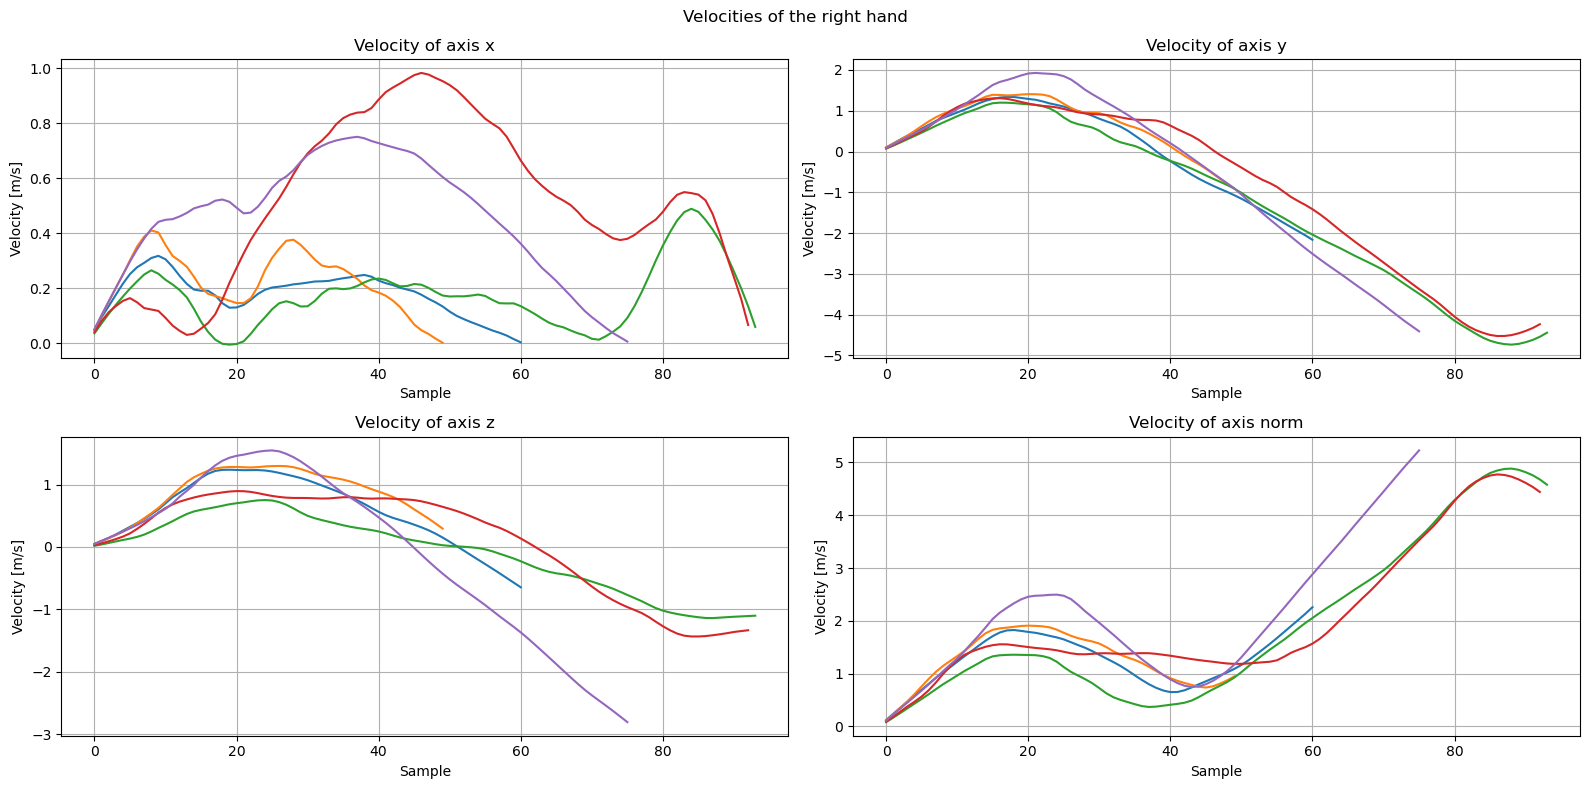

In [24]:
def calc_velocities(acceleration):
    '''
    #Input: Acceleration and optional plot
    #Calculates the velocities based on the accelerations with the assumption that v(0) = 0. Simpsons method was used to approximate the velocities. Optional argument plot to specify whether to plot the velocities or not.
    Output: Velocities based on the accelerations with the assumption that v(0) = 0.
    '''
    #Simpsons integral has a higher order integration error than the standard forward euler method. This basically attempts to reduce the errors in the velocities
    vel_x = scipy.integrate.cumulative_simpson(acceleration["x"], dx = 1/50)
    #We are finding all indices where the signal crosses the x-axis
    zero_crossings =  np.where(np.diff(np.sign(vel_x)))[0]

    #Find the first time we cross the axis past 25 samples (to avoid early crosses from starting the movement). 25 was heuristically selected.
    end_idx = zero_crossings[np.where(zero_crossings > 25)[0][0]]+1
    vel_x = vel_x[0:end_idx]

    #This makes forward movements towards the target positive.
    vel_x = vel_x * np.sign(np.mean(vel_x))

    vel_y = scipy.integrate.cumulative_simpson(acceleration["y"], dx = 1/50)
    vel_y = vel_y[0:end_idx]
    vel_z = scipy.integrate.cumulative_simpson(acceleration["z"], dx = 1/50)
    vel_z = vel_z[0:end_idx]
    df_vel = pd.DataFrame([vel_x, vel_y, vel_z], ["x", "y", "z"]).transpose()
    df_vel["norm"] = df_vel.apply(np.linalg.norm, axis = 1)

    #Since we are cutting off the acceleration, we should also shorten the accelerations for other calculations.
    acceleration = acceleration.iloc[0:end_idx, :]

    return [df_vel, acceleration]
list_acc_data_reduced = [[],[]]
list_acc_data = [zero_mean_left_acc_hand, zero_mean_right_acc_hand]
list_velocities = []
for i,acc_side in enumerate(list_acc_data):
    for j, trial_acc in enumerate(acc_side):
        #Calculate features
        [velocities, accelerations] = calc_velocities(trial_acc)
        list_acc_data_reduced[i].append(accelerations)
        list_velocities.append(velocities)
    #plt.show()
list_acc_data = list_acc_data_reduced


num_cols = 2
num_rows = 2
fig, axes = plt.subplots(num_cols, num_rows, figsize = (16, 8))
axis = ["x", "y", "z", "norm"]
it = 0
for i in range(num_rows):
    for j in range(num_cols):
        for k in range(0,5):  # Iterate over the first 4 dataframes or less if less than 4
            axes[i, j].plot(list_velocities[k][axis[it]])
        axes[i, j].set_title(f'Velocity of axis {axis[it]}')
        axes[i, j].set_xlabel('Sample')
        axes[i, j].set_ylabel('Velocity [m/s]')
        axes[i, j].grid(True)
        it += 1  # Increment after plotting each axis
fig.suptitle("Velocities of the left hand")
plt.tight_layout()
plt.show()

num_cols = 2
num_rows = 2
fig, axes = plt.subplots(num_cols, num_rows, figsize = (16, 8))
axis = ["x", "y", "z", "norm"]
it = 0
for i in range(num_rows):
    for j in range(num_cols):
        for k in range(5,10):  # Iterate over the first 4 dataframes or less if less than 4
            axes[i, j].plot(list_velocities[k][axis[it]])
        axes[i, j].set_title(f'Velocity of axis {axis[it]}')
        axes[i, j].set_xlabel('Sample')
        axes[i, j].set_ylabel('Velocity [m/s]')
        axes[i, j].grid(True)
        it += 1  # Increment after plotting each axis
fig.suptitle("Velocities of the right hand")
plt.tight_layout()
plt.show()



The axis may be a bit confusing at first. Weren't the accelerations the other way? For our own sanity checks, we have flipped the x-axis to make sure that forward movements are positive. This doesn't affect the features that we will calculate however. What things do you notice in the velocities? Peak velocities really do not appear super different. But let's calculate them anyway. We already have the velocities. So, finding the peak should be relatively trivial. Let's get to it!

# Peak Velocity

In [25]:
def calc_peak_vel(velocity, axis= 'all'):
    '''
    #Input: Velocity and axis
    :param velocity: Velocity vector
    :param axis: the axis of which to calculate the peak velocity
    :return: peak absolute velocity of a given axis.
    '''
    peak_vel = []
    # Loop over the columns to find the peak velocities
    for i,col in enumerate(['x', 'y', 'z', 'norm']):
        #Calculate the peak velocity and append to peak_vel
        peak_vel.append()
    return  peak_vel


peak_velocities  = []
for velocities in list_velocities:
        #Append Features to list
        peak_velocity = calc_peak_vel(velocities, axis = "all")
        peak_velocities.append(peak_velocity)

num_cols = 2
num_rows = 2
fig, axes = plt.subplots(num_cols, num_rows, figsize = (16, 8))
axis = ["x", "y", "z", "norm"]
trials= [1, 2, 3, 4, 5]
it = 0
for i in range(num_rows):
    for j in range(num_cols):
        axes[i,j].plot(trials, list(list(zip(*peak_velocities[0:5]))[it]))
        axes[i,j].plot(trials, list(list(zip(*peak_velocities[5:]))[it]))
        axes[i, j].set_title(f'Peak velocity of axis {axis[it]}')
        axes[i, j].set_xlabel('Trial')
        axes[i, j].set_xticks(range(1,6))
        axes[i, j].set_ylabel('Peak velocity [m/s]')
        axes[i, j].grid(True)
        axes[i, j].legend(["Left", "Right"])
        it= it + 1

plt.tight_layout()
plt.show()

TypeError: list.append() takes exactly one argument (0 given)

Interestingly enough, the peak velocities appear highest for the affected arm! There does seem to be quite a variability in the direction of the target. Clearly not enough data to make a strong conclusion about how well the peak velocities can define quality, but good to keep in mind nonetheless. Looking back into the initial velocity figure, that is not really surprising either. A potential explanation might be that the movement itself is not necessarily much slower here, but less efficient.

# Movement Smoothness - Log Dimensionless Jerk
Let's get into an actual smoothness feature: The log dimensionless jerk. Very briefly, the log dimensionless jerk is the integral of squared absolute jerk (instantaneous rate of change of the accelerations) compensated by a factor (here we use $\frac{\text{(movement time)}^{3}}{(\text{peak velocity)}^2}$). In formula form: $\text{LDJ} = -ln( \frac{t_{mov}^{3}}{v_{peak}^{2}} \cdot \int_{t0}^{t1}|a(t)dt|^2dt)$. For the integration we recommend using a standard scipy function (like scipy.integrate.simpson). $a(t)$ here is the acceleration. The minus at the end is to make sure that a less negative value also corresponds to a smoother movement.

If you aren't an expert in how to convert mathematical functions into code, don't worry. We will talk you through it.

In [ ]:
def calc_log_dimensionless_jerk(peak_vel, acceleration):
    '''
    #Input: movement_time, peak_vel, acceleration, axis
    :param movement_time: Duration of the trial movement
    :param peak_vel: The peak velocity during that specific trial
    :param acceleration: Acceleration vector
    :return: log dimensionless jerk of a given axis
    '''
    #Step 1 is to calculate the norm of the accelerations. We have been using this in velocities, but haven't made one for the accelerations. If you are lost, look in the code above.
    acceleration = acceleration.copy()
    acceleration.loc[:, "norm"] =

    #The jerk is defined as the derivative of the accelerations. An easy way to obtain this in discrete cases is to use the differences between samples. As the time step becomes smaller and smaller, this should converge to the true derivative. np.gradient can do this if we give a vector and the time steps.
    abs_jerk_squared =

    #We also need the movement time of this trial. Since we shortened the movement, lets re-evaluate it:
    movement_time =

    #Empty list to store the LDJ for each axis in.
    log_dimensionless_jerk = []

    # Loop over the columns to compute integrals and log_dimensionless_jerk
    for i,col in enumerate(['x', 'y', 'z', 'norm']):
        #We need to integrate this over the entire movement, since we have already sliced the data into trials, we can just integrate an entire movement. scipy.integrate has some nice functions for this.
        integral_ajs =

        #Now we need to make the integral dimensionless by multiplying it by the factor from the text above.
        dimensionless_jerk =
        #print(integral_ajs)
        #And now take the logarithm and multiply it by -1. And append it to the list.
        log_dimensionless_jerk.append()
    return  log_dimensionless_jerk

list_LDJ = []
i = 0

for acc_side in list_acc_data:
    for trial_acc in acc_side:
        peak_velocity = peak_velocities[i]
        LDJ = calc_log_dimensionless_jerk(peak_velocity, trial_acc)
        list_LDJ.append(LDJ)
        i = i + 1

num_cols = 2
num_rows = 2
fig, axes = plt.subplots(num_cols, num_rows, figsize = (16, 8))
axis = ["x", "y", "z", "norm"]
trials= [1, 2, 3, 4, 5]
it = 0
for i in range(num_rows):
    for j in range(num_cols):
        axes[i,j].plot(trials, list(list(zip(*list_LDJ[0:5]))[it]))
        axes[i,j].plot(trials, list(list(zip(*list_LDJ[5:]))[it]))
        axes[i, j].set_title(f'Log dimensionless jerk of {axis[it]}')
        axes[i, j].set_xlabel('Trial')
        axes[i, j].set_xticks(range(1,6))
        axes[i, j].set_ylabel('Log dimensionless jerk [1]')
        axes[i, j].grid(True)
        axes[i, j].legend(["Left", "Right"])
        it= it + 1

plt.tight_layout()
plt.show()

 In log dimensionless jerk, a less negative means a smoother movement. Here we see that the movements from the left side are indeed smoother than the right - the affected - side. Contrary to the peak velocities, these differences appear consistent in the aprticipant. We should keep in mind that literature says that LDJ is very sensitive to noise and looking at the accelerations. Remember, the jerk is directly related to the changes in the acceleration, if there is a lot of noise in the measurement, the changes due to the movement become difficult to untangle from the noise. This is important to keep in mind in your own applications.

# Movement smoothness - SPectral ARClength

Perhaps SPARC will do better. SPARC or the SPectral ARClength is calculated by obtaining the fourier transform of the velocity profile within a specific frequency range. Mathematically: $-\int^{\omega_{c}}_0\sqrt{(\frac{1}{\omega_c})^2+(\frac{d\hat{V}(\omega)}{d \omega})^2}d\omega$ with $\hat{V}(\omega) = \frac{V(\omega)}{V(0)}$ and $\omega_c \triangleq min\{w_c^{max}, min\{\omega, \hat{V}(r) < \bar{V} \text{ } \forall \text{ } r>\omega\}\}$. The first term is used to normalize the arc length with respect to the cut-off frequency $\omega_{c}$

Again, don't get scared by the math. This is a more complicated metric to calculate, so we have taken the liberty to do it for you. We followed the MATLAB implementation of Balasubramanian, but with some minor changes to make it work in Python. If you have any questions about the implementation, feel free to do so.

In [ ]:
def calc_SPARC(velocity, fs, parameters=[0.05, 20, 4]):
    '''
    #Input: Velocity, fs and axis optional parameters
    :param velocity: Velocity vector
    :param fs: Sample frequency
    :param axis: Axis of which to calculate the SPARC
    :param parameters: Parameters of the SPARC, default [0.05, 20, 4] as recommended by Balasubramanian. The first number is the amplitude threshold. The second number is the maximum frequency cut-off and the third contains the zero padding.
    :return: The SPARC of a given velocity profile on a specified axis
    '''
    #We make an empty list to hold the SPARC for each of the axes
    SPARC = []
    for i,axis in enumerate(['x', 'y', 'z', 'norm']):
        #First we need to determine the number of points for the Fast Fourier Transform
        N = len(velocity[axis])
        #Add parameter[2] for the zero padding. Lower than 4 is not recommended. Numpy uses the Cooley-Turkey algorithm to calculate the FFT. This algorithm is optimal for data with a length equal to a power of 2. For computational efficiency we can include this, but it is not necessary.
        Nfft = int(2**np.ceil(np.log2(N)+parameters[2]))
        #Calculate the fast fourier transform of the velocity profile
        vel_spect = np.abs(np.fft.fft(velocity[axis], Nfft))

        #Create a frequency vector
        dt = 1/fs
        freq = np.arange(0, ((1/dt)*(Nfft-1)/Nfft) + (1/dt)*(1/Nfft), (1/dt)*(1/Nfft))

        #Normalize the spectrum
        vel_spect = vel_spect/np.max(vel_spect)

        #Find the index that is always above the amplitude threshold and within the cut-off frequency
        inxFc = np.where((freq <= parameters[1]) & (vel_spect >= parameters[0]))[0][-1]

        #Select the relevant spectrum
        vel_spect = vel_spect[0:inxFc]

        #Calculate the arc-length
        dArcLength = np.sqrt((1/inxFc))**2 + np.diff(vel_spect)**2
        #and sum the arc-lengths for the smoothness and multiply by -1
        SPARC.append(-1*np.sum(dArcLength))
    return SPARC

fs = 50
i = 0
#list_acc_data = [zero_mean_left_acc_hand, zero_mean_right_acc_hand]
list_SPARC = []
for acc_side in list_acc_data:
    for trial_acc in acc_side:
        SPARC = calc_SPARC(list_velocities[i], fs)
        #Append Features to list
        list_SPARC.append(SPARC)
        i = i+1

num_cols = 2
num_rows = 2
fig, axes = plt.subplots(num_cols, num_rows, figsize = (16, 8))
axis = ["x", "y", "z", "norm"]
trials= [1, 2, 3, 4, 5]

it = 0
for i in range(num_rows):
    for j in range(num_cols):
        axes[i,j].plot(trials, list(list(zip(*list_SPARC[0:5]))[it]))
        axes[i,j].plot(trials, list(list(zip(*list_SPARC[5:]))[it]))
        axes[i, j].set_title(f'SPARC of {axis[it]}')
        axes[i, j].set_xlabel('Trial')
        axes[i, j].set_xticks(range(1,6))
        axes[i, j].set_ylabel('SPARC [1]')
        axes[i, j].grid(True)
        axes[i, j].legend(["Left", "Right"])
        it= it + 1

plt.tight_layout()
plt.show()

Here, a less negative SPARC indicate a smoother movement. Here too, we see that the movements of the left hand is smoother than the right hand. Both SPARC and LDJ here are able to indicate a difference in movement smoothness in all axes.

# Joint angles

In [ ]:
def elbow_flexion_angle(Trials_R_bf2seg, side):
    upper = Trials_R_bf2seg['upperarm_IMU'].tolist()
    lower = Trials_R_bf2seg['lowerarm_IMU'].tolist()

    elbow_flexion_angle_alltrial = []

    for j in range(len(upper)):
        elbow_flexion_angle_singletrial = []

        for i in range(min(len(upper[j]), len(lower[j]))):
            x_wrist_projected = lower[j][i,:,0] - (np.dot(lower[j][i,:,0], lower[j][i,:,2]) / np.linalg.norm(upper[j][i,:,2])**2) * upper[j][i,:,2]
            Y = np.linalg.norm(np.cross(x_wrist_projected, upper[j][i,:,1]))
            X = np.dot(x_wrist_projected, upper[j][i,:,1])
            elbow_flexion_angle = np.arctan2(Y, X)
            elbow_flexion_angle = (elbow_flexion_angle / np.pi * 180)*-1+240

            if side == "left":
                elbow_flexion_angle= elbow_flexion_angle - 60

            elbow_flexion_angle_singletrial.append(elbow_flexion_angle)

        elbow_flexion_angle_alltrial.append(elbow_flexion_angle_singletrial)

    return elbow_flexion_angle_alltrial

# Calculate elbow flexion angles for left and right sides
elbow_flexion_angle_left = elbow_flexion_angle(Trials_R_Left_bf2seg, "left")
elbow_flexion_angle_right = elbow_flexion_angle(Trials_R_Right_bf2seg, "right")


# Plot results for left and right sides
num_trials = 5
fig, axes = plt.subplots(num_trials, 2, figsize=(16, num_trials*4))

for i in range(num_trials):
    axes[i, 0].plot(elbow_flexion_angle_left[i])
    axes[i, 0].set_title('Left Trial {}'.format(i+1))
    axes[i, 0].set_xlabel('Time Point')
    axes[i, 0].set_ylabel('Elbow Flexion Angle (degrees)')
    axes[i, 0].grid(True)

    axes[i, 1].plot(elbow_flexion_angle_right[i])
    axes[i, 1].set_title('Right Trial {}'.format(i+1))
    axes[i, 1].set_xlabel('Time Point')
    axes[i, 1].set_ylabel('Elbow Flexion Angle (degrees)')
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()